In [88]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_intervals(labels):
    intervals = []

    l = len(labels)
    i = 0
    label = labels[0]

    for j in range(l):
        if label != labels[j]:
            intervals.append((label, i, j))
            i = j
            label = labels[j]

    intervals.append((label, i, l))

    return intervals

In [3]:
def extract_features(signal, n = 5):
    coeffs = fft.fft(signal)

    l = len(coeffs)
    freqs = fft.fftfreq(l)
    amps = np.abs(coeffs)
    
    l //= 2
    amps = amps[0 : l]
    freqs = freqs[0 : l]
   
    p = amps.argsort()
    freqs = freqs[p]
    amps = amps[p]

    features = []

    i = 0
    while i < n :
        i += 1

        feature = [0, 0]

        if l > 0 :
            l -= 1
            feature = [amps[l-1], abs(freqs[l-1])]

        features.append(feature)

    return features

In [75]:
def convert_to_1d_array(data_2d):
    data_1d = []
    
    for point in data_2d:
        data_1d.append(point[0])
        
    return np.array(data_1d)

In [5]:
def get_signal_sample_features(signal, labels, n = 5, sampling_rate = 700, window_len = 30):
    samples = (sampling_rate*window_len)
    
    baseline_av = 0
    intervals = get_intervals(labels)

    sample_features = {
        1 : [],
        2 : [],
        3 : [],
        4 : []
    }

    for interval in intervals :
        label = interval[0]
        beg = interval[1]
        end = interval[2]

        if label > 4 :
            continue
    
        part_of_signal = signal[beg : end]

        if label == 0 :
            baseline_av = np.mean(part_of_signal)
            continue
        
        part_of_signal -= baseline_av
        
        l = len(part_of_signal)

        while l > 0 :
            sub_part = part_of_signal[max(0, l-samples) : l]
            l -= samples // 2

            features = extract_features(sub_part, n)
            sample_features[label].append(features)

    return sample_features

In [6]:
def get_subject(s_no) :
    path = '../WESAD/S' + str(s_no) + '/S' + str(s_no) + '.pkl'
    subject = pd.read_pickle(path)

    return subject

In [78]:
def convert_to_df(sample_features):
    df = pd.DataFrame(columns=['label', 'amp', 'freq'])

    ref = {
        1 : 'Baseline',
        2 : 'Stress',
        3 : 'Amusement',
        4 : 'Meditation'
    }

    for label in sample_features :
        for points in sample_features[label] :
            for point in points :
                df = df.append({
                    'label' : ref[label],
                    'amp' : point[0],
                    'freq' : point[1]
                }, ignore_index=True)

    return df

In [79]:
def get_chest_sample_features(subject) :
    chest_signals = subject['signal']['chest']
    labels = subject['label']

    signal_features = {}
    for signal_type in chest_signals :
        if signal_type == 'ACC' :
            continue
        
        signal = convert_to_1d_array(chest_signals[signal_type])
        sample_features = get_signal_sample_features(signal, labels)
        signal_features[signal_type] = convert_to_df(sample_features)

    return signal_features

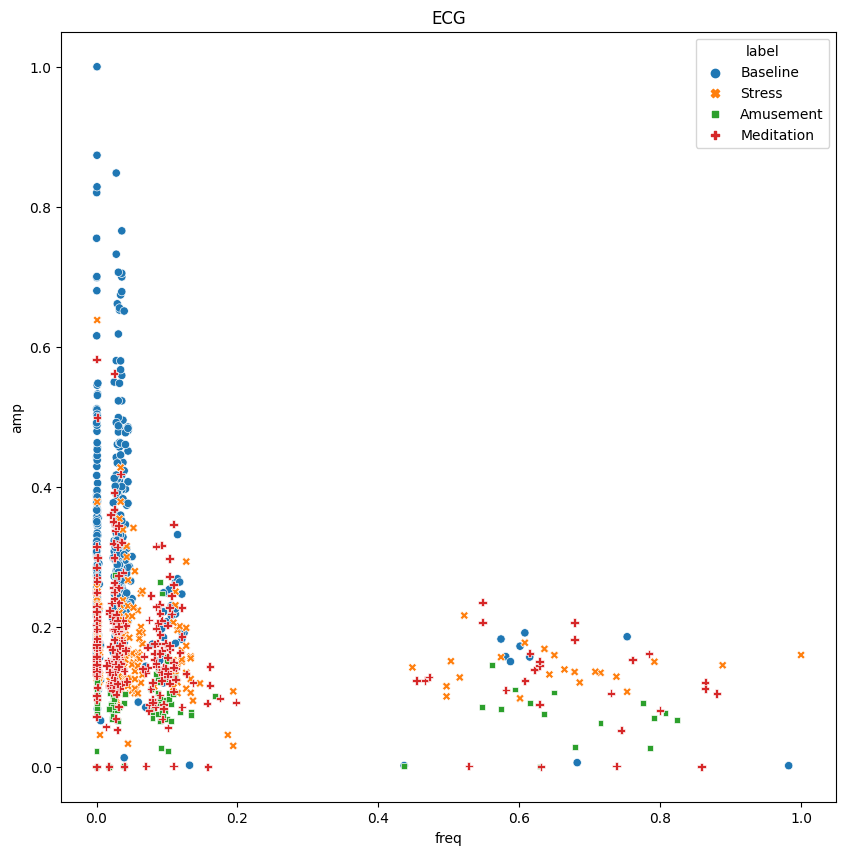

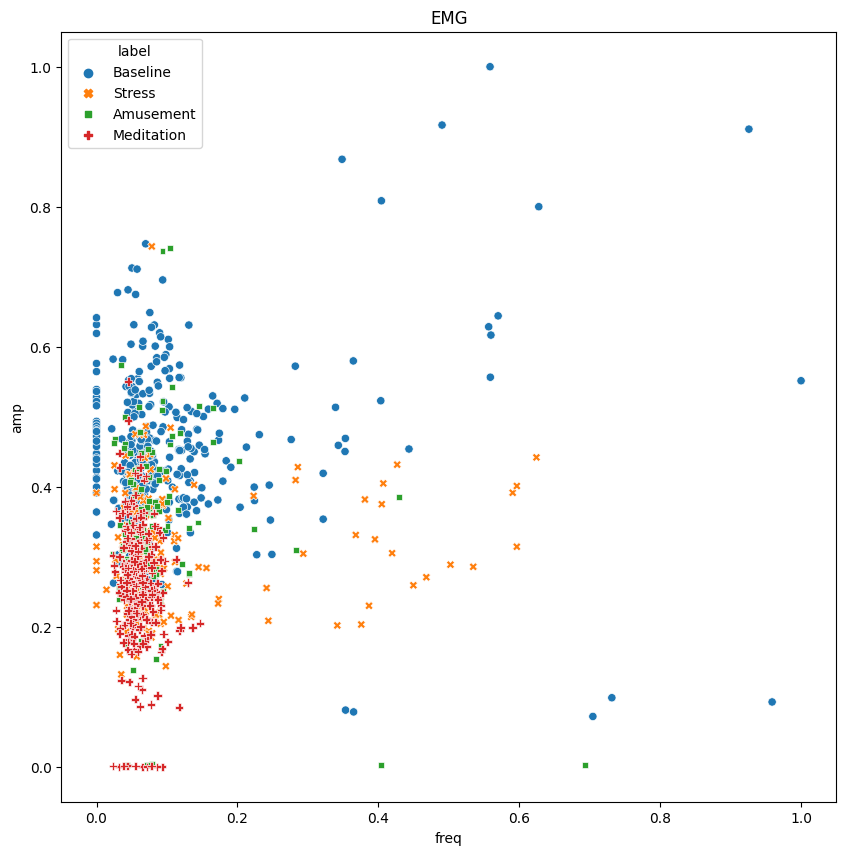

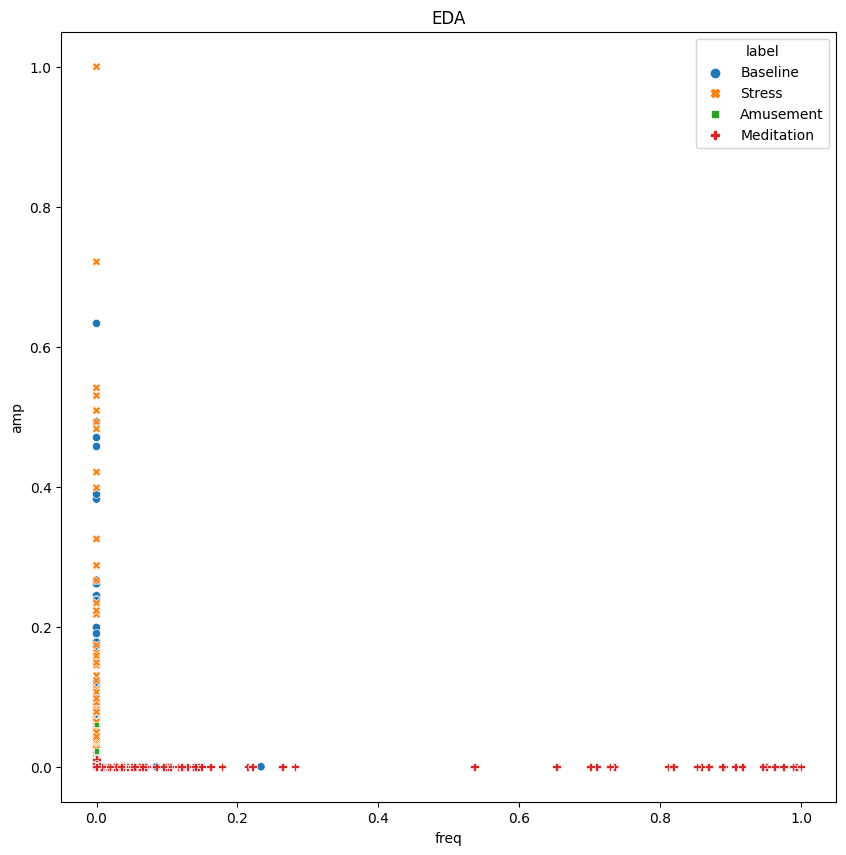

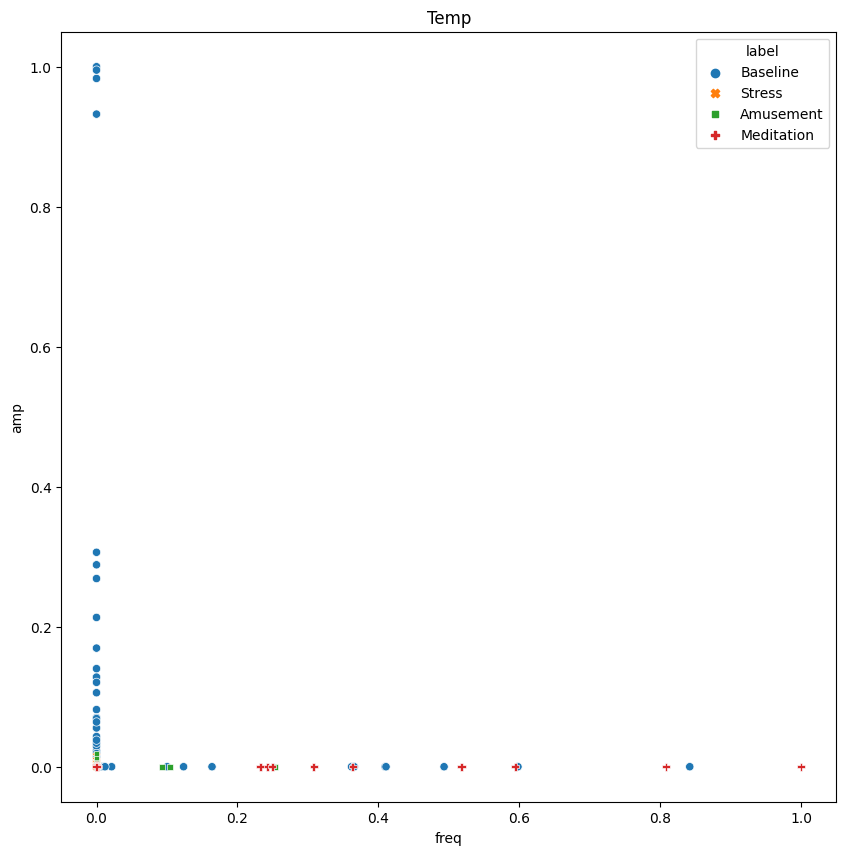

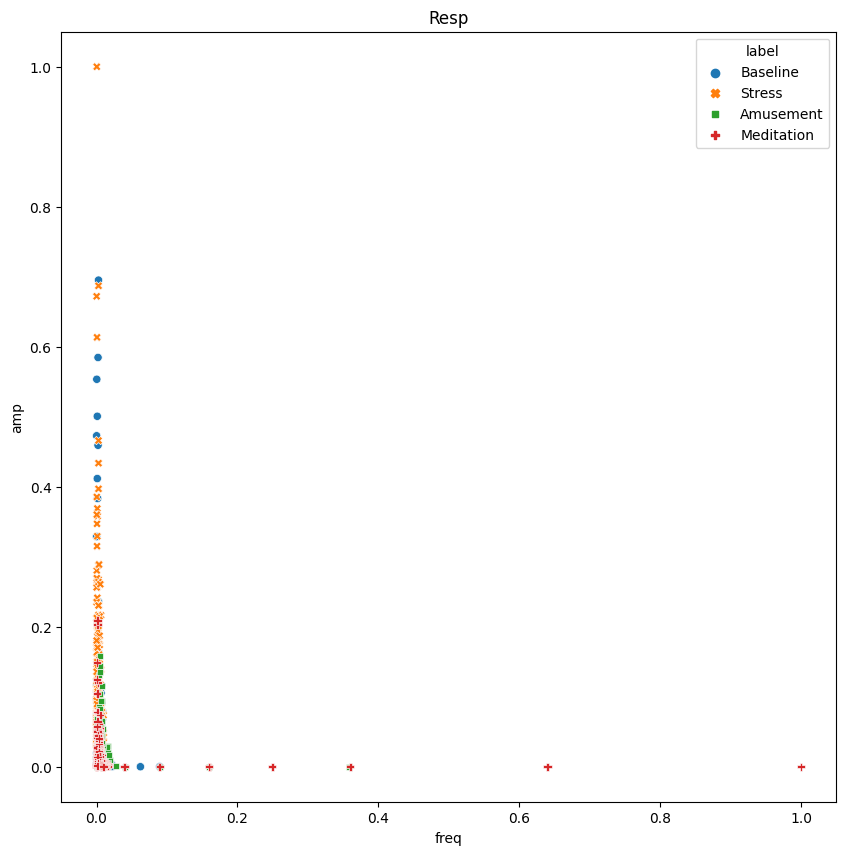

In [89]:
subject= get_subject(2)
chest_signal_features = get_chest_sample_features(subject)

plt.style.use('default')

for signal_type in chest_signal_features :
    df = chest_signal_features[signal_type]
    df[['amp', 'freq']] = MinMaxScaler().fit_transform(df[['amp', 'freq']])
    df[['amp', 'freq']] = np.square(df[['amp', 'freq']])
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data = df, x = 'freq', y = 'amp', hue = 'label', style= 'label').set(title=signal_type)

{'ECG':           label                      amp   freq
 0      Baseline  [[0.04643205914772234]]  [0.0]
 1      Baseline  [[0.04643205914772234]]  [0.0]
 2      Baseline  [[0.04643205914772234]]  [0.0]
 3      Baseline  [[0.04643205914772234]]  [0.0]
 4      Baseline  [[0.04643205914772234]]  [0.0]
 ..          ...                      ...    ...
 975  Meditation  [[0.03055555900286207]]  [0.0]
 976  Meditation  [[0.03055555900286207]]  [0.0]
 977  Meditation  [[0.03055555900286207]]  [0.0]
 978  Meditation  [[0.03055555900286207]]  [0.0]
 979  Meditation  [[0.03055555900286207]]  [0.0]
 
 [980 rows x 3 columns],
 'EMG':           label                        amp   freq
 0      Baseline  [[0.0012082392052669088]]  [0.0]
 1      Baseline  [[0.0012082392052669088]]  [0.0]
 2      Baseline  [[0.0012082392052669088]]  [0.0]
 3      Baseline  [[0.0012082392052669088]]  [0.0]
 4      Baseline  [[0.0012082392052669088]]  [0.0]
 ..          ...                        ...    ...
 975  Meditati

In [47]:
print(subject['signal']['chest'].keys())
print(subject['signal']['wrist'].keys())

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
